In [230]:
from scipy.spatial import Delaunay
from skimage.io import imread
import scipy.misc
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt
import glob
from PIL import Image 
import os
from random import randint

In [231]:
def get_face_landmarks(img, add_boundary_points=True, predictor_path = 'shape_predictor_68_face_landmarks.dat'):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(predictor_path)
  dets = detector(img, 1)
  points = np.zeros((68, 2))
  for k, d in enumerate(dets):
    shape = predictor(img, d) # get the landmarks for the face \ in box d.
    for i in range(68):
      points[i, 0] = shape.part(i).x
      points[i, 1] = shape.part(i).y
  points = points.astype(np.int32)
  return points

In [232]:
def weighted_average_points(start_points, end_points, percent=0.5):
     if percent <= 0: return end_points
     elif percent >= 1: return start_points
     else: return np.asarray(start_points*percent + \
            end_points*(1-percent), np.int32)

def weighted_average(img1, img2, percent=0.5):
     if percent <= 0: return img2
     elif percent >= 1: return img1
     else: return cv2.addWeighted(img1, percent, img2, \
            1-percent, 0)

In [233]:
def bilinear_interpolate(image, coords):
    int_coords = coords.astype(np.int32)
    x0, y0 = int_coords
    dx, dy = coords - int_coords
    q11, q21, q12, q22 = image[y0, x0], image[y0, x0+1], \
                         image[y0+1, x0], image[y0+1, x0+1]
    btm = q21.T * dx + q11.T * (1 - dx)
    top = q22.T * dx + q12.T * (1 - dx)
    interpolated_pixels = top * dy + btm * (1 - dy)
    return interpolated_pixels.T

In [234]:
def get_grid_coordinates(points):
  xmin, xmax = np.min(points[:, 0]), np.max(points[:, 0]) + 1
  ymin, ymax = np.min(points[:, 1]), np.max(points[:, 1]) + 1
  return np.asarray([(x, y) for y in range(ymin, ymax)
         for x in range(xmin, xmax)], np.uint32)


In [235]:
def process_warp(src_img, result_img, tri_affines, dst_points, delaunay):
    roi_coords = get_grid_coordinates(dst_points)
    roi_tri_indices = delaunay.find_simplex(roi_coords)
    for simplex_index in range(len(delaunay.simplices)):
        coords = roi_coords[roi_tri_indices == simplex_index]
        num_coords = len(coords)
        out_coords = np.dot(tri_affines[simplex_index], 
                     np.vstack((coords.T, np.ones(num_coords))))
        x, y = coords.T
        result_img[y, x] = bilinear_interpolate(src_img, \
                                out_coords)
    return None

In [236]:
def gen_triangular_affine_matrices(vertices, src_points, dest_points):
    ones = [1, 1, 1]
    for tri_indices in vertices:
        src_tri = np.vstack((src_points[tri_indices, :].T, ones))
        dst_tri = np.vstack((dest_points[tri_indices, :].T, ones))
        mat = np.dot(src_tri, np.linalg.inv(dst_tri))[:2, :]
        yield mat

In [237]:
def warp_image(src_img, src_points, dest_points, dest_shape):
 num_chans = 3
 src_img = src_img[:, :, :3]
 rows, cols = dest_shape[:2]
 result_img = np.zeros((rows, cols, num_chans), np.uint8)
 delaunay = Delaunay(dest_points)
 tri_affines = np.asarray(list(gen_triangular_affine_matrices(delaunay.simplices, 
                               src_points, dest_points)))    
 process_warp(src_img, result_img, tri_affines, dest_points, delaunay)
 return result_img, delaunay

In [238]:
src_path = 's1.jpg'
dst_path = 'sr1.jpg' 
src_img = imread(src_path)
dst_img = imread(dst_path)
size = dst_img.shape[:2]
src_img = cv2.resize(src_img[...,:3], size)
src_points = get_face_landmarks(src_img)
dst_points = get_face_landmarks(dst_img)

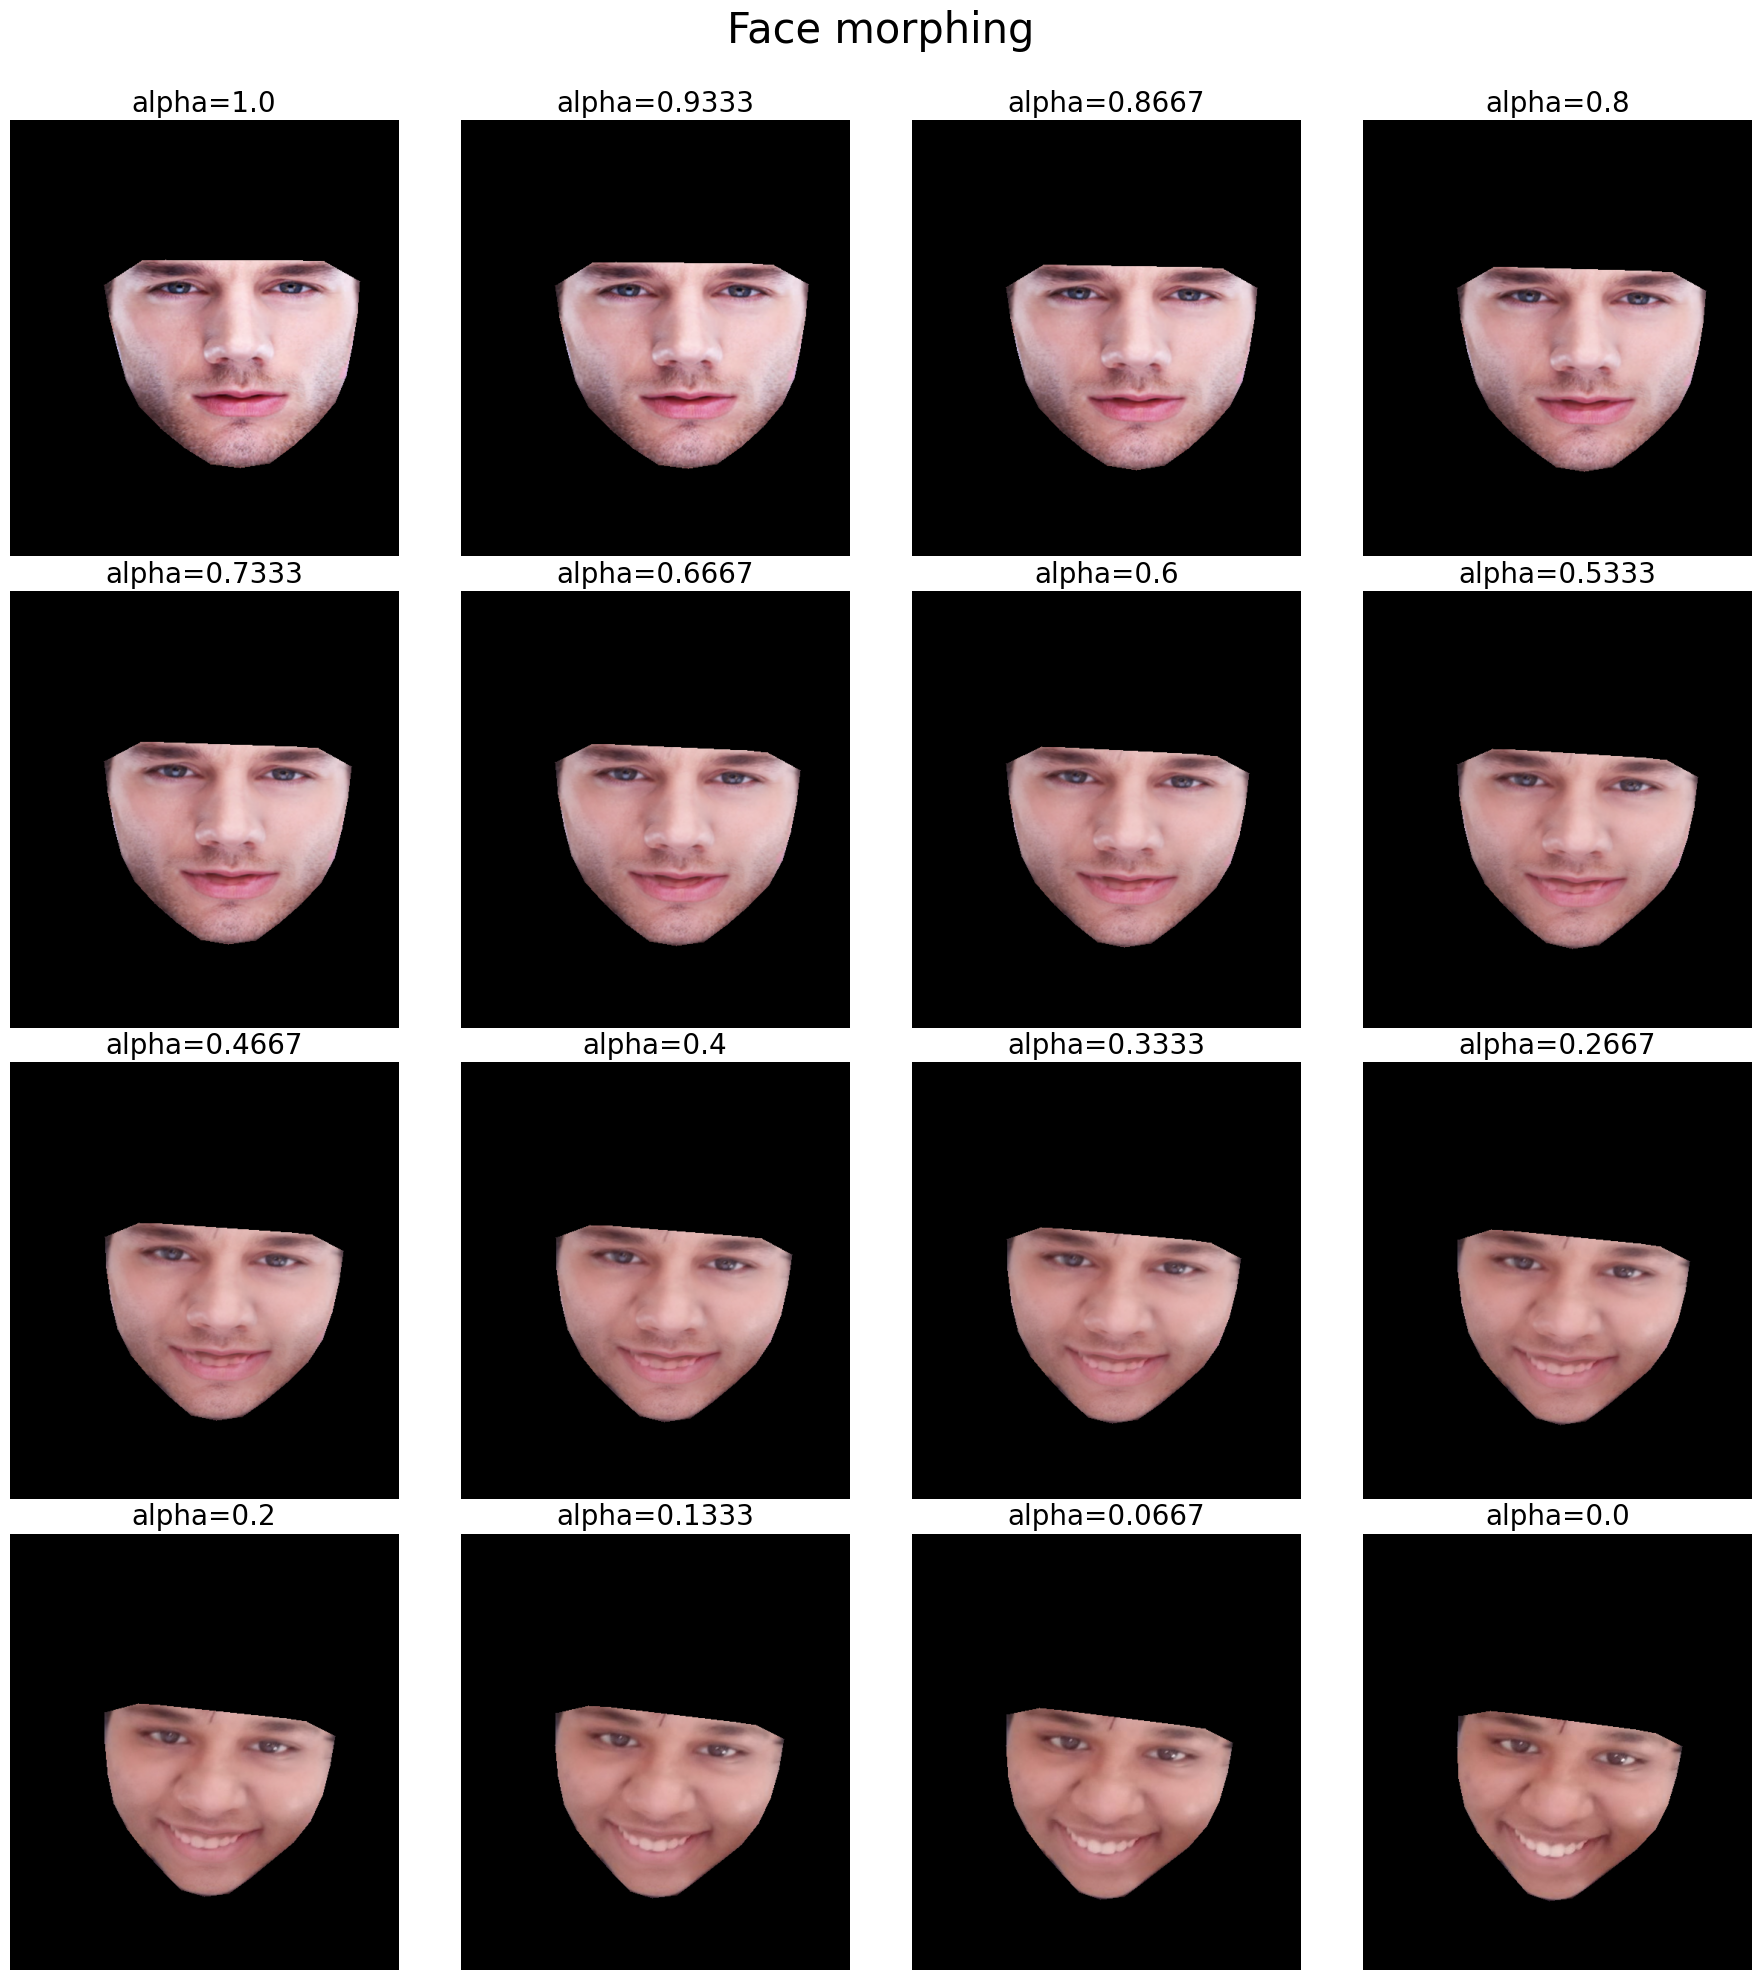

In [239]:
fig = plt.figure(figsize=(18,20))
fig.subplots_adjust(top=0.925, bottom=0, left=0, right=1, \
                    wspace=0.01,  hspace=0.08)
i = 1
lst = []
for percent in np.linspace(1, 0, 16):
 points = weighted_average_points(src_points, dst_points, percent)
 src_face, src_d = warp_image(src_img, src_points, points, size)
 end_face, end_d = warp_image(dst_img, dst_points, points, size)
 average_face = weighted_average(src_face, end_face, percent)
 lst.append(average_face)
 plt.subplot(4,4,i), plt.imshow(average_face)
 plt.title('alpha=' + str(round(percent,4)), size=20), \
            plt.axis('off')
 i += 1
plt.suptitle('Face morphing', size=30)
plt.show()

In [240]:
#creating a directory
path_dir = 'C:/Users/preth/OneDrive/Desktop/umbc course works/Second semester/DAA/trail2'
val = randint(0,10)
dir = 'Out'+str(val)
os.mkdir(os.path.join(path_dir,dir))
for i in range(len(lst)):
    #save image
    #imageio.imwrite('morph'+str(i+1)+'.jpg',lst[i])
    im = Image.fromarray(lst[i])
    im.save(f"{path_dir}/"+dir+"/"+'morph'+str(i+1)+'.jpg')

In [241]:
im = Image.fromarray(lst[1])
wid = im.width
hei = im.height
frameSize = (wid,hei)
out = cv2.VideoWriter(path_dir+'/'+dir+'/'+'output_video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 1, frameSize)
for i in range(1,17):
    for f_name in glob.glob('C:/Users/preth/OneDrive/Desktop/umbc course works/Second semester/DAA/trail2/'+dir+'/'+str1):
        img = cv2.imread(f_name)
        out.write(img)
    str1 = 'morph'+str(i)+'.jpg'
out.release()

In [242]:
cap = cv2.VideoCapture(path_dir+'/'+dir+'/'+'output_video.mp4')
if (cap.isOpened() == False):
    print("Error opening video file")
while(cap.isOpened()):
    ret,frame = cap.read()
    if ret == True:
        cv2.imshow('Frame',frame)
        if cv2.waitKey(200) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()

In [243]:
dir

'Out1'